# PREPARACIÓN DE LOS DATOS

En esta fase se procede a crear nuevas variables o transformar las existentes para poder dar mejor respuesta al objetivo de negocio.

## IMPORTE DE LIBRERIAS

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy = True 

## CARGA DE LOS DATOS

In [5]:
con = sa.create_engine('sqlite:///../Datos/AIRBNB.db')

df = pd.read_sql('df', con = con)
df.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,85.0,5,...,t,2,1.0,1.0,106,4.88,4.86,4.84,5863,Chamartín
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.41476,-3.70418,Entire home/apt,65.0,5,...,f,2,1.0,2.0,172,4.63,4.78,4.90,5877,Centro
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,...,f,1,1.0,1.0,33,4.58,4.82,4.21,2592,Latina
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,94.0,5,...,f,3,1.0,1.0,33,4.91,4.97,5.00,5877,Centro
4,26825,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29.0,3,...,t,1,1.0,1.0,196,4.72,4.72,4.73,4524,Arganzuela


## PREPARACIÓN DE VARIABLES

### CREACIÓN DE LOS KPI'S

Para este análisis se procede a iniciar con la creación de las variables de análisis, es decir las que se habían identificado como posibles Kpis que influyen sobre el negocio.

Las cuales en este modelo se consideran como 3:

* **Precio por noche:** esta se tiene directamente en la variable price, por lo que se revisará para entender la información que entrega.
* **Ocupación:** Se tiene la variable availability_365 pero es necesario ajustarla.
* **Precio del inmueble:** Esta variable no se encuentran dentro de las variables iniciales, por lo que se procederá a crearla utilizando las variables externas.

**Se procede a iniciar el precio por noche.**

La documentación no aclara si el precio es por todo el inmueble, o si en el caso de que se alquile una habitación es por habitación.

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Se intentará entender la variable analizando el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Así que primero se analizará un distrito relevante (con muchos datos).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21395 entries, 0 to 21394
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              21395 non-null  int64  
 1   name                            21395 non-null  object 
 2   host_id                         21395 non-null  int64  
 3   neighbourhood_group             21395 non-null  object 
 4   neighbourhood                   21395 non-null  object 
 5   latitude                        21395 non-null  float64
 6   longitude                       21395 non-null  float64
 7   room_type                       21395 non-null  object 
 8   price                           21395 non-null  float64
 9   minimum_nights                  21395 non-null  int64  
 10  calculated_host_listings_count  21395 non-null  int64  
 11  availability_365                21395 non-null  int64  
 12  host_is_superhost               

In [7]:
df.distrito.value_counts()

distrito
Centro                   9321
Salamanca                1464
Chamberí                 1433
Tetuán                   1191
Arganzuela               1017
Carabanchel               762
Retiro                    749
Ciudad Lineal             682
Chamartín                 648
Puente de Vallecas        592
Latina                    576
Usera                     561
Moncloa - Aravaca         515
Hortaleza                 461
San Blas - Canillejas     456
Fuencarral - El Pardo     305
Villaverde                210
Barajas                   146
Moratalaz                 126
Villa de Vallecas         103
Vicálvaro                  77
Name: count, dtype: int64

In [8]:
df.loc[df.distrito == 'Centro', :].groupby('room_type').price.mean()

room_type
Entire home/apt    147.022296
Private room        95.678801
Shared room         95.604278
Name: price, dtype: float64

Conclusión:
    
* Alquilar el apartamento tiene un precio medio de 147€
* Alquilar una habitación tiene un precio medio de 95€ ya sea compartida o privada
* Por tanto para calcular los "ingresos" de un inmueble se debe multiplicar el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room

**Ahora vamos con la ocupación**

La variable obtenida de la base de datos que permite medir el nivel de ocupación es availability_365.

Esta variable dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto sería importante transformarla a una medida más directa de ocupación.

Es posible hacerlo con una tranformación directa.

In [10]:
df['ocupacion'] = (365 - (df.availability_365).astype('int64'))

In [11]:
df[['availability_365', 'ocupacion']].head(10)

,availability_365,ocupacion
0,22,343
1,0,365
2,135,230
3,168,197
4,295,70
5,274,91
6,351,14
7,0,365
8,137,228
9,147,218


Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%.

Por tanto se debe ponderarlo por el porcentaje medio de habitaciones alquiladas.

No se tiene ese dato, pero para el caso de estudio se asumirá un porcentaje del 70%.

Es posible crear la variable de ingreso anual estimado aplicando apply sobre una función personalizada.

In [12]:
def precio_total(registro):
    if ((registro.bedrooms > 1) & (registro.room_type == 'Private room') | (registro.room_type == 'Share room')):
        salida = registro.price * registro.bedrooms * 0.7 * registro.ocupacion
    else:
        salida = registro.price * registro.ocupacion

    return salida

df['ingreso_anual_estimado'] = df.apply(precio_total, axis = 1)

In [13]:
df[['room_type', 'bedrooms', 'price', 'ingreso_anual_estimado']].sort_values(by = 'ingreso_anual_estimado', ascending = True).head(30) 

,room_type,bedrooms,price,ingreso_anual_estimado
13153,Entire home/apt,2.0,986.0,0.0
6738,Entire home/apt,1.0,165.0,0.0
10838,Private room,1.0,250.0,0.0
12062,Entire home/apt,2.0,125.0,0.0
12390,Private room,1.0,49.0,0.0
10528,Entire home/apt,1.0,375.0,0.0
3714,Private room,1.0,48.0,0.0
10966,Entire home/apt,1.0,65.0,0.0
15328,Private room,1.0,160.0,0.0
15688,Private room,1.0,52.0,0.0


### TRANSFORMACIÓN DE LAS VARIABLES DE ANÁLISIS

Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente este análisis es más efectivo cuando se discretiza la variable de análisis.

Para el caso de estudio las candidatas para este análisis son: accommodates, bedrooms, beds y number_of_reviews.

En bedrooms tiene sentido una discretización más personalizada. En las otras se puede realizar de manera automática.

**Discretizar la variable Bedrooms**

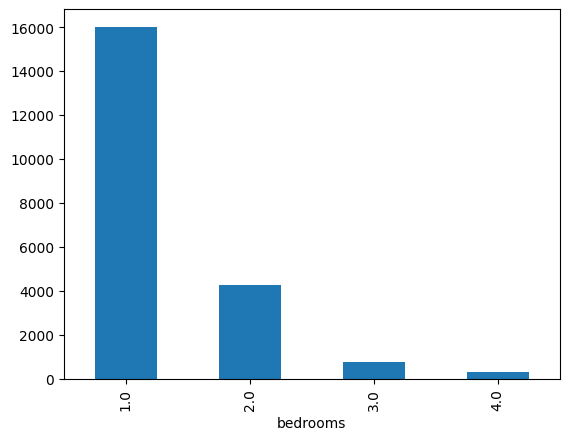

In [14]:
df.bedrooms.value_counts().plot.bar();

Se procede a discretizar para 1, 2, 3 y 4 habitaciones.

In [15]:
condiciones = [(df.bedrooms == 1), (df.bedrooms == 2), (df.bedrooms == 3), (df.bedrooms == 4)]
resultados = ['01_Una', '02_Dos', '03_Tres', '04_Cuatro']

df['bedrooms_discretizadas'] = np.select(condiciones, resultados, default = -999)
df.bedrooms_discretizadas.value_counts()

bedrooms_discretizadas
01_Una       16020
02_Dos        4283
03_Tres        780
04_Cuatro      312
Name: count, dtype: int64

**Discretizar accommodates, beds y number_of_reviews**

Para este análisis se comprendera los percentiles 0.5, 0.8 y 1

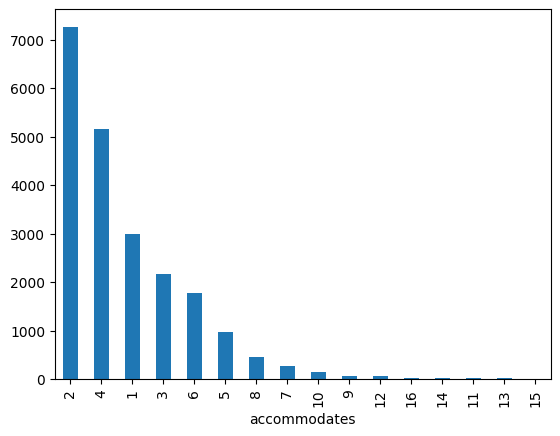

In [16]:
df.accommodates.value_counts().plot.bar();

In [17]:
df['accommodates_discretizadas'] = pd.qcut(df.accommodates, [0, 0.5, 0.8, 1], 
        labels = ['0-3', '4', '5-16'])

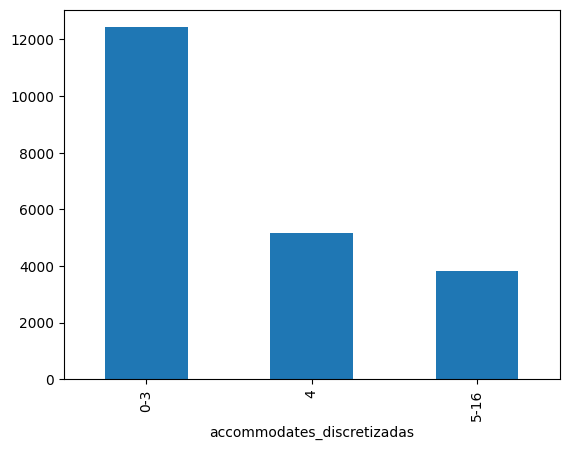

In [18]:
df.accommodates_discretizadas.value_counts().plot.bar();

In [19]:
df['beds_discretizadas'] = pd.qcut(df.beds, [0, 0.5, 0.8, 1],
                                  labels = ['0-2', '3', '3-40'])

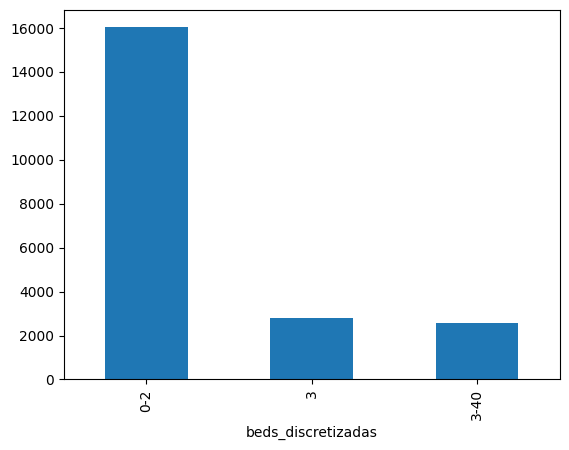

In [20]:
df.beds_discretizadas.value_counts().plot.bar();

In [21]:
df['reviews_discretizadas'] = pd.qcut(df.number_of_reviews, [0, 0.5, 0.8, 1],
                                  labels = ['0-13', '14-72', '73-994'])

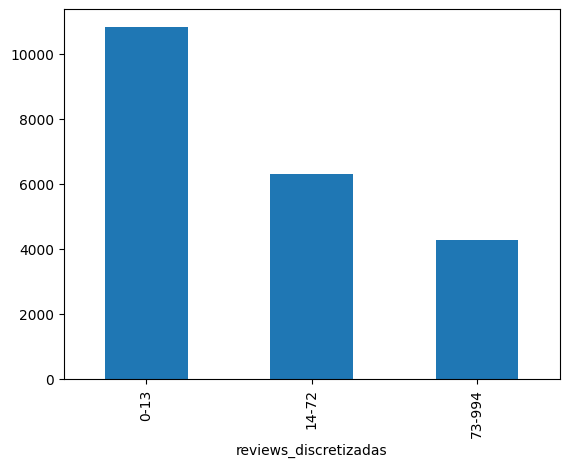

In [22]:
df.reviews_discretizadas.value_counts().plot.bar();

### CREACIÓN DE VARIABLES CON DATOS EXTERNOS

En este caso en concreto existen muchas posibilidades por analizar por medio de los datos externos.

Lo primero, que ya ha sido incorporado parcialmente, es la palanca del precio del inmueble.

Se aclaro la posibilidad de estimar esta variable a traves utilizando los metros cuadrados del inmueble por el precio por m2 según el distrito.

El precio_m2 ya se encuentra contemplado en los datos, pero el tamaño del inmueble no se encuentra disponible.

Para continuar con el análisis se procede a obtener un valor de m2 base a partir del número de habitaciones encontradas en el inmueble.

No es perfecto, pero se considera una aproximación apropiada como punto de partida.

**Estimación de los metros cuadrados del inmueble**

Se utilizará el siguiente criterio:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120

In [23]:
condiciones = [(df.bedrooms == 1), (df.bedrooms == 2), (df.bedrooms == 3), (df.bedrooms == 4)]
resultados = [50, 70, 90, 150]

df['m2'] = np.select(condiciones, resultados, default = -999)

In [24]:
df.m2.value_counts()

m2
50     16020
70      4283
90       780
150      312
Name: count, dtype: int64

Ahora es posible estimar el precio de compra del inmueble.

Se aclara que al precio obtenido se le deduce un 30% como valor esperado a obtener por medio del equipo de negociación.

In [25]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

In [26]:
df[['bedrooms', 'm2', 'distrito', 'precio_m2', 'precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,1.0,50,Chamartín,5863,205205.0
1,1.0,50,Centro,5877,205695.0
2,1.0,50,Latina,2592,90720.0
3,1.0,50,Centro,5877,205695.0
4,1.0,50,Arganzuela,4524,158340.0
5,2.0,70,Centro,5877,287973.0
6,1.0,50,Centro,5877,205695.0
7,2.0,70,Centro,5877,287973.0
8,1.0,50,Centro,5877,205695.0
9,1.0,50,Centro,5877,205695.0


**Cálculo del retorno a la inversión [ROI]**

In [27]:
df['roi_en_%'] = df['ingreso_anual_estimado'] / df['precio_compra'] * 100
df[['bedrooms', 'price', 'ocupacion', 'ingreso_anual_estimado', 'precio_compra', 'roi_en_%']].sort_values(by = 'roi_en_%', ascending = False).head(20)

,bedrooms,price,ocupacion,ingreso_anual_estimado,precio_compra,roi_en_%
7039,1.0,8469.0,275,2328975.0,158340.0,1470.869648
5269,3.0,6000.0,365,2190000.0,179676.0,1218.860616
5014,1.0,3000.0,365,1095000.0,99820.0,1096.974554
5005,2.0,3000.0,365,1533000.0,139748.0,1096.974554
12124,1.0,4000.0,275,1100000.0,121065.0,908.602817
7332,1.0,3000.0,365,1095000.0,121065.0,904.472804
5169,2.0,2000.0,365,1022000.0,139748.0,731.316369
5128,3.0,5000.0,365,1825000.0,285012.0,640.323916
12557,1.0,3600.0,365,1314000.0,205695.0,638.809888
4911,2.0,2300.0,365,839500.0,139748.0,600.724161


### ANÁLISIS DE PUNTOS DE INTERÉS

En turismo la localización es muy importante.

Por ejemplo se puede calcular las distancias a diferentes puntos de interés como monumentos, lugares de ocio, recintos deportivos, etc. Y analizar el impacto de estos sitios en los costos de los inmuebles de la zona.

Para el caso de estudio y como complemento del mismo se procede a calcular la distancia de cada inmueble a la Puerta del Sol.

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.

Una búsqueda en Google permite obtener da una función ya construída para calcularla que podemos adaptar al caso de estudio: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [28]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Se crea la variable requerida

In [29]:
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

In [30]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.722768
Arganzuela                1.911375
Chamberí                  2.133212
Retiro                    2.464352
Salamanca                 2.765725
Moncloa - Aravaca         3.436434
Latina                    3.762314
Carabanchel               3.856156
Usera                     3.954145
Puente de Vallecas        4.533238
Chamartín                 4.576883
Tetuán                    4.705994
Moratalaz                 5.017935
Ciudad Lineal             5.147599
Villaverde                7.645335
Fuencarral - El Pardo     7.974068
Hortaleza                 8.002169
San Blas - Canillejas     8.290899
Villa de Vallecas         9.315375
Vicálvaro                 9.371527
Barajas                  11.487938
Name: pdi_sol, dtype: float64

## SE GUARDA LOS CAMBIOS EN EL DATAMART

In [31]:
df.to_sql('df_preparado', con = con, if_exists = 'replace', index = False)

21395